# TP3 - Deep Learning : Méthodologie, Expérimentations et Régularisation 

<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Auteur : </span>TOURE Boubacar (<a href="boubacar.toure@etud.univ-angers.fr">boubacar.toure@etud.univ-angers.fr</a>), étudiant en Master 2 Informatique à la faculté des sciences d'Angers</p>
<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Professeur Référent : </span>Sylvain Lamprier (<a href="sylvain.lamprier@univ-angers.fr">sylvain.lamprier@univ-angers.fr</a>)</p>

Supports adaptés de Nicolas Baskiotis (<a href="nicolas.baskiotis@sorbonne-univeriste.fr">nicolas.baskiotis@sorbonne-univeriste.fr</a>) et Benjamin Piwowarski (<a href="benjamin.piwowarski@sorbonne-universite.fr">benjamin.piwowarski@sorbonne-universite.fr</a>) -- MLIA/ISIR, Sorbonne Université

# Import du projet

In [2]:
import matplotlib.pyplot as plt
import torch.nn as nn
import shutil
import torch
import time
import os

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.autonotebook import tqdm
from tqdm import tqdm

# Déclaration des fonctions 

In [3]:
def save_state(fichier,epoch,model,optim):
    state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state,fichier)

def load_state(fichier,model,optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch

def unnormalize(img, mean, std):
    if img.dim()==2 or ((img.dim()==3) and (img.size()[0]==1)):
        return img*std[0]+mean[0]
    return img * img.new(std).view(3, 1, 1) + img.new(mean).view(3, 1, 1)


def train(model, train_loader, validation_loader, loss_fn, optimizer, epochs, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train-{typeTrain}.pth"
    
    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train")
    
    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []

    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        accuracy = correct / total
        accuraciesOfTrain.append(accuracy)
        summary.add_scalar("Accuracy_Of_Train", accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))
            
        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            save_state(check_file, epoch, model, optimizer)
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            accuraciesOfValidation.append(accuracy)
            summary.add_scalar("Accuracy_Of_Validation", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))
            
            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss/len(train_loader), accuracy))
    end_time = time.time()
    
    trainTime = end_time - start_time
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

def set_dropout_rate(m, rate):
    if type(m) == nn.Dropout:
        m.p = rate

def train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs, dropout_rate, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train_dropout"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train_dropout")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train_dropout-{typeTrain}.pth"
    
    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train_dropout")
    
    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []
    
    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        model.apply(lambda x: set_dropout_rate(x, dropout_rate))
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        accuracy = correct / total
        accuraciesOfTrain.append(accuracy)
        summary.add_scalar("Accuracy_Of_Train", accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))
            
        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            model.eval()
            model.apply(lambda x: set_dropout_rate(x, 0))
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            accuraciesOfValidation.append(accuracy)
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))
            
            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss/len(train_loader), accuracy))
    end_time = time.time()
    trainTime = end_time - start_time
    
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train_dropout
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

def train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train_batchnorm"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train_batchnorm")

    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train_batchnorm-{typeTrain}.pth"

    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train_batchnorm")

    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []

    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        accuracy = correct / total
        accuraciesOfTrain.append(accuracy)
        summary.add_scalar("Accuracy_Of_Train", accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))

        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            accuraciesOfValidation.append(accuracy)
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))

            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss/len(train_loader), accuracy))
    end_time = time.time()
    trainTime = end_time - start_time
    
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train_batchnorm
    
    return trainTime, trainModelComplexity, validation_loss, accuracy


# requiert que les modules soient enregistrés dans une liste model.hidden_layers
def addWeightsHisto(writer, model, epoch):                
    ix = 0
    for module in model.hidden_layers:
        if isinstance(module, nn.Linear):
            writer.add_histogram(f'Linear/{ix}/weight', module.weight, epoch)
            ix += 1

# Déclaration des class

In [4]:
class LinearMultiClass(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClass, self).__init__()
        self.name = "Linear_Multi_Class"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.activation(x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

class LinearMultiClassWithDropout(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, dropout_rate=0.5, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClassWithDropout, self).__init__()
        self.name = "Linear_Multi_Class_With_Dropout"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.dropout_rate = dropout_rate
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))
            self.dropout_layers.append(nn.Dropout(p=self.dropout_rate))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout_layers[i](x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

class LinearMultiClassWithBatchNorm(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClassWithBatchNorm, self).__init__()
        self.name = "Linear_Multi_Class_With_BatchNorm"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))
            self.batch_norm_layers.append(nn.BatchNorm1d(h))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.batch_norm_layers[i](x)
            x = self.activation(x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x


# Déclaration des données du projet

In [5]:
#Transformations à appliquer sur le dataset (transformation des images en tenseurs et normalization pour obtenir des valeurs entre -1 et 1)
mean = [0.5]
std = [0.5]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Téléchargement des données (via le dataset specifique MNIST de pytorch)
mnist_train = MNIST('./data', train=True, transform=transform, download=True)
mnist_test = MNIST('./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(mnist_test, batch_size=batch_size)

TB_PATH = f"/tmp/logs/deepLearning"
epoch = 100

in_size = 784
out_size = 10
hidden_layers = [100, 100, 100]

# Récuperation d'une image de notre batch de données

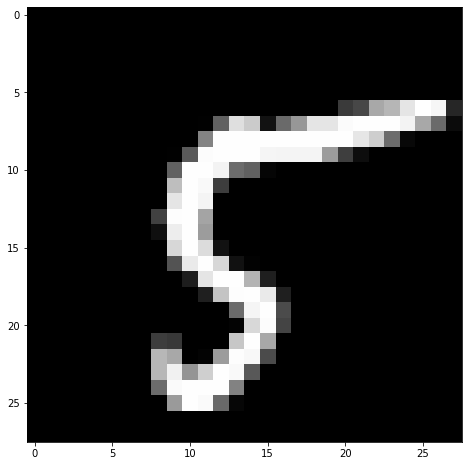

In [6]:
imgs,labs = next(iter(train_loader))

# dimension of images (flattened)reload_ext tensorboard
HEIGHT,WIDTH = imgs.shape[2], imgs.shape[3] # taille de l'image
INPUT_DIM = HEIGHT * WIDTH

#Visualisation de la première image
img = unnormalize(imgs[0], mean, std) # pour retrouver l'image d'origine (avant normalisation)
fig = plt.figure(figsize=(8, 8))

plt.imshow(img.squeeze(),cmap='Greys_r')

# Construction et Entrainement des modèles

## Modèle LinearMultiClass

### Avec activation = nn.Tanh

	Epoch 0, Validation Loss: 187.2655, Validation Accuracy: 0.7750
Epoch 1, Train Loss: 0.9485, Train Accuracy: 0.8104
Epoch 2, Train Loss: 0.6553, Train Accuracy: 0.8612
Epoch 3, Train Loss: 0.5176, Train Accuracy: 0.8807
Epoch 4, Train Loss: 0.4415, Train Accuracy: 0.8909
Epoch 5, Train Loss: 0.3943, Train Accuracy: 0.8984
Epoch 6, Train Loss: 0.3626, Train Accuracy: 0.9028
Epoch 7, Train Loss: 0.3397, Train Accuracy: 0.9070
Epoch 8, Train Loss: 0.3218, Train Accuracy: 0.9103
Epoch 9, Train Loss: 0.3076, Train Accuracy: 0.9134
	Epoch 10, Validation Loss: 44.4029, Validation Accuracy: 0.9197
Epoch 11, Train Loss: 0.2854, Train Accuracy: 0.9185
Epoch 12, Train Loss: 0.2766, Train Accuracy: 0.9207
Epoch 13, Train Loss: 0.2685, Train Accuracy: 0.9223
Epoch 14, Train Loss: 0.2608, Train Accuracy: 0.9251
Epoch 15, Train Loss: 0.2539, Train Accuracy: 0.9265
Epoch 16, Train Loss: 0.2473, Train Accuracy: 0.9285
Epoch 17, Train Loss: 0.2412, Train Accuracy: 0.9304
Epoch 18, Train Loss: 0.2354, T

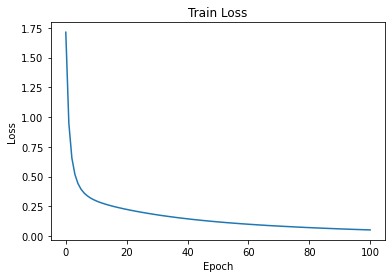

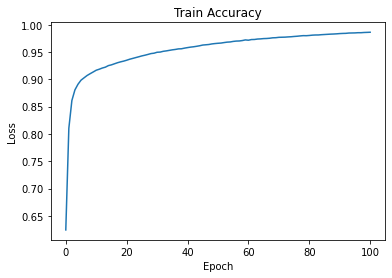

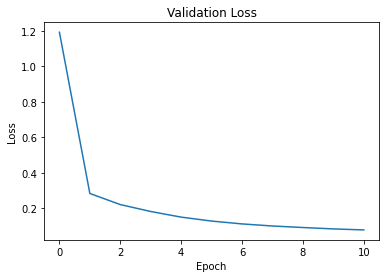

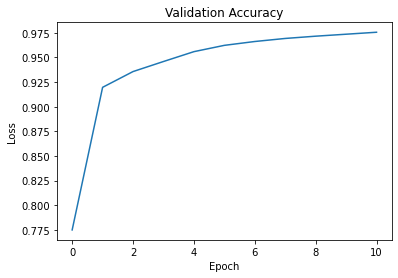

In [7]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.Tanh())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhAdam, model1ComplexityTanhAdam, model1ValidationLossTanhAdam, model1AccuracyTanhAdam = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="Tanh-Adam")

	Epoch 0, Validation Loss: 363.0778, Validation Accuracy: 0.0666
Epoch 1, Train Loss: 2.3099, Train Accuracy: 0.0688
Epoch 2, Train Loss: 2.3053, Train Accuracy: 0.0779
Epoch 3, Train Loss: 2.3008, Train Accuracy: 0.0944
Epoch 4, Train Loss: 2.2963, Train Accuracy: 0.1182
Epoch 5, Train Loss: 2.2918, Train Accuracy: 0.1402
Epoch 6, Train Loss: 2.2874, Train Accuracy: 0.1588
Epoch 7, Train Loss: 2.2830, Train Accuracy: 0.1725
Epoch 8, Train Loss: 2.2787, Train Accuracy: 0.1827
Epoch 9, Train Loss: 2.2744, Train Accuracy: 0.1903
	Epoch 10, Validation Loss: 356.0027, Validation Accuracy: 0.2064
Epoch 11, Train Loss: 2.2659, Train Accuracy: 0.2036
Epoch 12, Train Loss: 2.2616, Train Accuracy: 0.2107
Epoch 13, Train Loss: 2.2574, Train Accuracy: 0.2179
Epoch 14, Train Loss: 2.2532, Train Accuracy: 0.2252
Epoch 15, Train Loss: 2.2490, Train Accuracy: 0.2332
Epoch 16, Train Loss: 2.2448, Train Accuracy: 0.2406
Epoch 17, Train Loss: 2.2406, Train Accuracy: 0.2486
Epoch 18, Train Loss: 2.2365, 

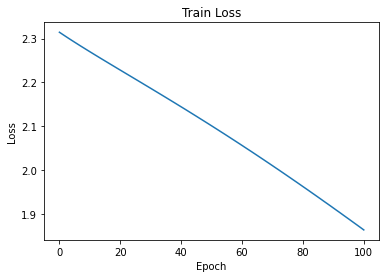

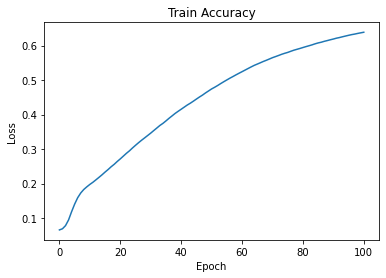

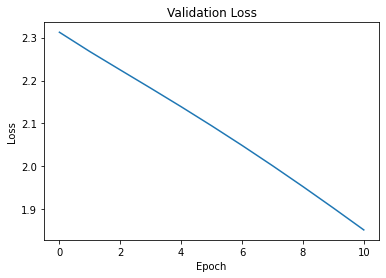

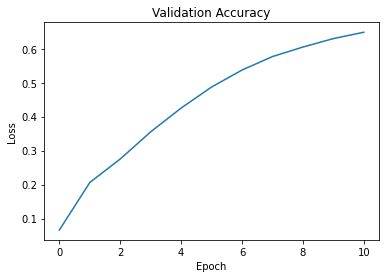

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 0:14:56 ago. (Use '!kill 2537' to kill it.)

In [8]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.Tanh())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhSGD, model1ComplexityTanhSGD, model1ValidationLossTanhSGD, model1AccuracyTanhSGD = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="Tanh-SGD")

### Avec activation = nn.ReLU

	Epoch 0, Validation Loss: 183.3738, Validation Accuracy: 0.7997
Epoch 1, Train Loss: 0.8830, Train Accuracy: 0.8233
Epoch 2, Train Loss: 0.5876, Train Accuracy: 0.8606
Epoch 3, Train Loss: 0.4777, Train Accuracy: 0.8764
Epoch 4, Train Loss: 0.4225, Train Accuracy: 0.8855
Epoch 5, Train Loss: 0.3894, Train Accuracy: 0.8920
Epoch 6, Train Loss: 0.3672, Train Accuracy: 0.8970
Epoch 7, Train Loss: 0.3507, Train Accuracy: 0.9003
Epoch 8, Train Loss: 0.3379, Train Accuracy: 0.9037
Epoch 9, Train Loss: 0.3275, Train Accuracy: 0.9060
	Epoch 10, Validation Loss: 47.1698, Validation Accuracy: 0.9142
Epoch 11, Train Loss: 0.3100, Train Accuracy: 0.9113
Epoch 12, Train Loss: 0.3026, Train Accuracy: 0.9129
Epoch 13, Train Loss: 0.2957, Train Accuracy: 0.9148
Epoch 14, Train Loss: 0.2895, Train Accuracy: 0.9168
Epoch 15, Train Loss: 0.2833, Train Accuracy: 0.9184
Epoch 16, Train Loss: 0.2774, Train Accuracy: 0.9200
Epoch 17, Train Loss: 0.2721, Train Accuracy: 0.9218
Epoch 18, Train Loss: 0.2665, T

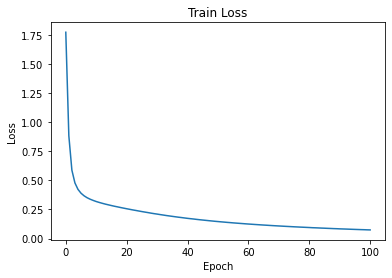

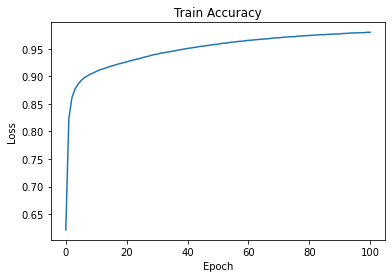

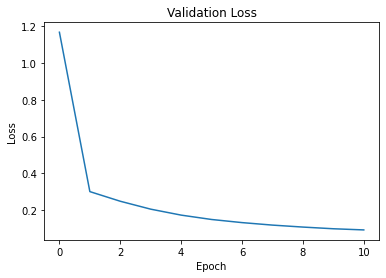

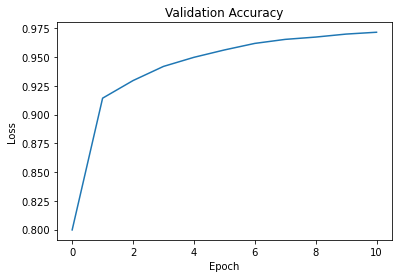

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 0:30:32 ago. (Use '!kill 2537' to kill it.)

In [9]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.ReLU())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhReLuAdam, model1ComplexityTanhReLuAdam, model1ValidationLossTanhReLuAdam, model1AccuracyTanhReLuAdam = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="ReLU-Adam")

	Epoch 0, Validation Loss: 361.4751, Validation Accuracy: 0.0998
Epoch 1, Train Loss: 2.3018, Train Accuracy: 0.1130
Epoch 2, Train Loss: 2.2999, Train Accuracy: 0.1303
Epoch 3, Train Loss: 2.2980, Train Accuracy: 0.1426
Epoch 4, Train Loss: 2.2961, Train Accuracy: 0.1501
Epoch 5, Train Loss: 2.2943, Train Accuracy: 0.1536
Epoch 6, Train Loss: 2.2925, Train Accuracy: 0.1552
Epoch 7, Train Loss: 2.2907, Train Accuracy: 0.1566
Epoch 8, Train Loss: 2.2889, Train Accuracy: 0.1577
Epoch 9, Train Loss: 2.2871, Train Accuracy: 0.1583
	Epoch 10, Validation Loss: 358.5428, Validation Accuracy: 0.1643
Epoch 11, Train Loss: 2.2835, Train Accuracy: 0.1608
Epoch 12, Train Loss: 2.2818, Train Accuracy: 0.1620
Epoch 13, Train Loss: 2.2800, Train Accuracy: 0.1634
Epoch 14, Train Loss: 2.2783, Train Accuracy: 0.1643
Epoch 15, Train Loss: 2.2766, Train Accuracy: 0.1656
Epoch 16, Train Loss: 2.2748, Train Accuracy: 0.1670
Epoch 17, Train Loss: 2.2731, Train Accuracy: 0.1684
Epoch 18, Train Loss: 2.2714, 

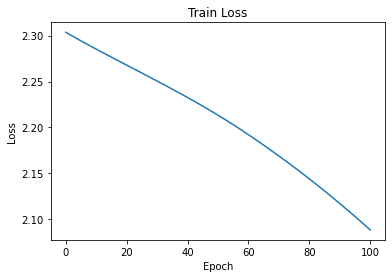

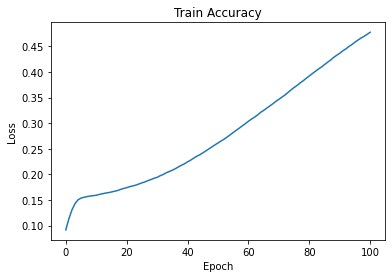

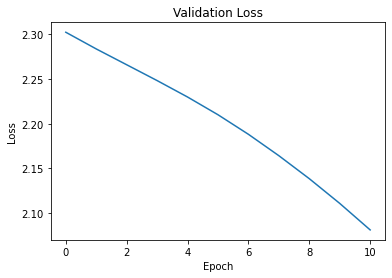

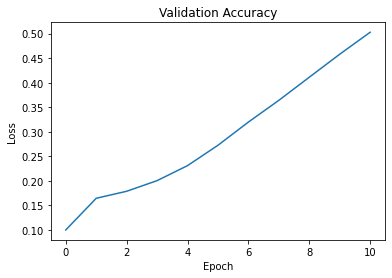

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 0:45:22 ago. (Use '!kill 2537' to kill it.)

In [10]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.ReLU())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhReLuSGD, model1ComplexityTanhReLuSGD, model1ValidationLossTanhReLuSGD, model1AccuracyTanhReLuSGD = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="ReLU-SGD")

### Comparaison entre les activations (Tanh & ReLU) et les optimiseurs (Adam & SGD)

La fonction d'activation Tanh (hyperbolique tangente) est une fonction de transfert sigmoid qui convertit une entrée linéaire en une sortie centrée autour de zéro dans l'intervalle [-1, 1]. Elle est souvent utilisée dans les réseaux de neurones de couches cachées pour normaliser les sorties des neurones.

La fonction d'activation ReLU (rectifiée linéaire) est une fonction de transfert non linéaire qui convertit toutes les entrées négatives en zéro. Il est utilisé pour résoudre le problème de décès du neurone, qui est un phénomène où les poids des neurones peuvent devenir négatifs et rester coincés à zéro.

En général, ReLU est considéré comme étant plus rapide et plus efficace pour les modèles de réseaux de neurones en raison de sa simplicité et de la vitesse de convergence plus rapide qu'il offre comparé à Tanh. Cependant, ReLU peut aussi causer des problèmes de saturation des neurones, où de nombreux neurones peuvent devenir saturés et ne pas produire de sortie. Cela peut rendre difficile la convergence du modèle. Tanh peut éviter ce problème mais il peut être plus lent à converger.

En fin de compte, le choix de la fonction d'activation dépend du modèle et des données sur lesquels vous travaillez et des performances que vous recherchez.

In [11]:
print ("Model Linear Multi Class With Tanh (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhAdam,"\n\tComplexité:", model1ComplexityTanhAdam, "\n\tValidation Loss:", model1ValidationLossTanhAdam, "\n\tAccurancy:", model1AccuracyTanhAdam, "] \n")
print ("Model Linear Multi Class With Tanh (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhSGD,"\n\tComplexité:", model1ComplexityTanhSGD, "\n\tValidation Loss:", model1ValidationLossTanhSGD, "\n\tAccurancy:", model1AccuracyTanhSGD, "] \n")

if model1ValidationLossTanhAdam <= model1ValidationLossTanhSGD:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")

Model Linear Multi Class With Tanh (Adam): [
	Temps d'exécution: 926.860333442688 
	Complexité: 235146 
	Validation Loss: 12.12764191540191 
	Accurancy: 0.9756 ] 

Model Linear Multi Class With Tanh (SGD): [
	Temps d'exécution: 895.7596008777618 
	Complexité: 235146 
	Validation Loss: 290.722198843956 
	Accurancy: 0.6485 ] 


___________________________________________________
Le Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !
___________________________________________________



In [12]:
print ("Model Linear Multi Class With ReLU (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuAdam, "\n\tComplexité:", model1ComplexityTanhReLuAdam, "\n\tValidation Loss:", model1ValidationLossTanhReLuAdam, "\n\tAccurancy:", model1AccuracyTanhReLuAdam, "] \n")
print ("Model Linear Multi Class With ReLU (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuSGD, "\n\tComplexité:", model1ComplexityTanhReLuSGD, "\n\tValidation Loss:", model1ValidationLossTanhReLuSGD, "\n\tAccurancy:", model1AccuracyTanhReLuSGD, "] \n")

if model1ValidationLossTanhReLuAdam <= model1ValidationLossTanhReLuSGD:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")

Model Linear Multi Class With ReLU (Adam): [
	Temps d'exécution: 935.0062861442566 
	Complexité: 235146 
	Validation Loss: 14.42888102401048 
	Accurancy: 0.9715 ] 

Model Linear Multi Class With ReLU (SGD): [
	Temps d'exécution: 889.6767272949219 
	Complexité: 235146 
	Validation Loss: 326.7288839817047 
	Accurancy: 0.5028 ] 


___________________________________________________
Le Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (Adam) est le plus performant !
___________________________________________________



In [13]:
print ("Model Linear Multi Class With Tanh (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhSGD,"\n\tComplexité:", model1ComplexityTanhSGD, "\n\tValidation Loss:", model1ValidationLossTanhSGD, "\n\tAccurancy:", model1AccuracyTanhSGD, "] \n")
print ("Model Linear Multi Class With ReLU (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuSGD, "\n\tComplexité:", model1ComplexityTanhReLuSGD, "\n\tValidation Loss:", model1ValidationLossTanhReLuSGD, "\n\tAccurancy:", model1AccuracyTanhReLuSGD, "] \n")

if model1ValidationLossTanhSGD <= model1ValidationLossTanhReLuSGD:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")

Model Linear Multi Class With Tanh (SGD): [
	Temps d'exécution: 895.7596008777618 
	Complexité: 235146 
	Validation Loss: 290.722198843956 
	Accurancy: 0.6485 ] 

Model Linear Multi Class With ReLU (SGD): [
	Temps d'exécution: 889.6767272949219 
	Complexité: 235146 
	Validation Loss: 326.7288839817047 
	Accurancy: 0.5028 ] 


___________________________________________________
Le Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (SGD) est le plus performant !
___________________________________________________



In [19]:
print ("Model Linear Multi Class With Tanh (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhAdam,"\n\tComplexité:", model1ComplexityTanhAdam, "\n\tValidation Loss:", model1ValidationLossTanhAdam, "\n\tAccurancy:", model1AccuracyTanhAdam, "] \n")
print ("Model Linear Multi Class With ReLU (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuAdam, "\n\tComplexité:", model1ComplexityTanhReLuAdam, "\n\tValidation Loss:", model1ValidationLossTanhReLuAdam, "\n\tAccurancy:", model1AccuracyTanhReLuAdam, "] \n")

if model1ValidationLossTanhAdam <= model1ValidationLossTanhReLuAdam:
    print("Donc nous pouvons conclure que l'usage de la fonction d'entrainement en utilisant l'activation <Tanh> est bien plus efficace que l'activation <ReLU>. De plus l'optimiseur <Adam> est bien plus performant que l'optimiseur <SGD> car parmi les modèles testés :")
    print("___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("Donc nous pouvons conclure que l'usage de la fonction d'entrainement en utilisant l'activation <ReLU> est bien plus efficace que l'activation <Tanh>. De plus l'optimiseur <Adam> est bien plus performant que l'optimiseur <SGD> car parmi les modèles testés :")
    print("___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")

Model Linear Multi Class With Tanh (Adam): [
	Temps d'exécution: 926.860333442688 
	Complexité: 235146 
	Validation Loss: 12.12764191540191 
	Accurancy: 0.9756 ] 

Model Linear Multi Class With ReLU (Adam): [
	Temps d'exécution: 935.0062861442566 
	Complexité: 235146 
	Validation Loss: 14.42888102401048 
	Accurancy: 0.9715 ] 

Donc nous pouvons conclure que l'usage de la fonction d'entrainement en utilisant l'activation <Tanh> est bien plus efficace que l'activation <ReLU>. De plus l'optimiseur <Adam> est bien plus performant que l'optimiseur <SGD> car parmi les modèles testés :
___________________________________________________
Le Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !
___________________________________________________



### Construction d'un histogramme avec les données du modèle

In [ ]:
summary = SummaryWriter(f"{TB_PATH}/{model.name}-historigramm")
addWeightsHisto(summary, model, epoch)

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir {TB_PATH}/{model.name}-historigramm

### Pénalisation des couches
Une première technique pour éviter le sur-apprentissage est de régulariser chaque couche par une pénalisation sur les poids, i.e. de favoriser des poids faibles. On parle de pénalisation L1 lorsque la pénalité est de la forme $\|W\|_1$ et L2 lorsque la norme L2 est utilisée : $\|W\|_2^2$. En pratique, cela consiste à rajouter à la fonction de coût globale du réseau un terme en $\lambda Pen(W)$ pour les paramètres de chaque couche que l'on veut régulariser.

#### Pour la norme L2 de 10^-5

__________________LA NORME L2 DE 10^−5 (Adam)__________________
	Epoch 0, Validation Loss: 27.2451, Validation Accuracy: 0.9483
Epoch 1, Train Loss: 0.1638, Train Accuracy: 0.9499
Epoch 2, Train Loss: 0.1329, Train Accuracy: 0.9595
Epoch 3, Train Loss: 0.1210, Train Accuracy: 0.9624
Epoch 4, Train Loss: 0.1143, Train Accuracy: 0.9648
Epoch 5, Train Loss: 0.0994, Train Accuracy: 0.9694
Epoch 6, Train Loss: 0.0943, Train Accuracy: 0.9699
Epoch 7, Train Loss: 0.0898, Train Accuracy: 0.9714
Epoch 8, Train Loss: 0.0856, Train Accuracy: 0.9723
Epoch 9, Train Loss: 0.0805, Train Accuracy: 0.9744
	Epoch 10, Validation Loss: 16.6746, Validation Accuracy: 0.9659
Epoch 11, Train Loss: 0.0732, Train Accuracy: 0.9762
Epoch 12, Train Loss: 0.0776, Train Accuracy: 0.9754
Epoch 13, Train Loss: 0.0736, Train Accuracy: 0.9763
Epoch 14, Train Loss: 0.0731, Train Accuracy: 0.9759
Epoch 15, Train Loss: 0.0737, Train Accuracy: 0.9764
Epoch 16, Train Loss: 0.0665, Train Accuracy: 0.9784
Epoch 17, Train Loss:

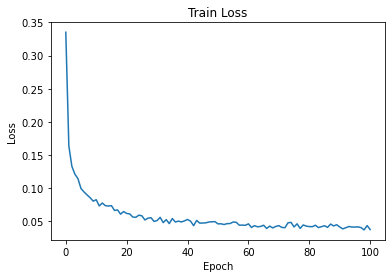

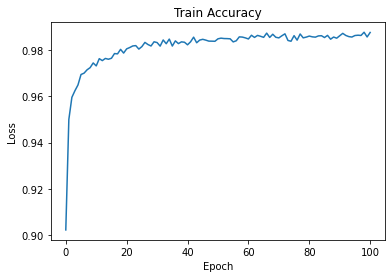

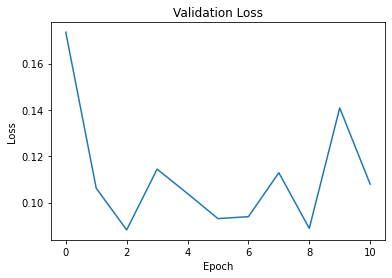

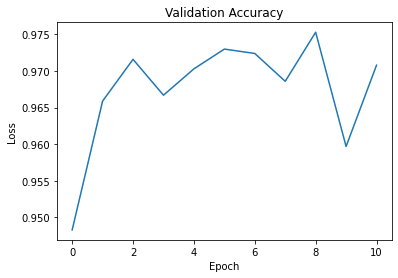

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 1:14:20 ago. (Use '!kill 2537' to kill it.)

(930.5406358242035, 99710, 16.952931223495398, 0.9708)

In [21]:
print("__________________LA NORME L2 DE 10^−5 (Adam)__________________")
weight_decay = 10e-5
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-5")

__________________LA NORME L2 DE 10^−5 (SGD)__________________
	Epoch 0, Validation Loss: 335.5591, Validation Accuracy: 0.4462
Epoch 1, Train Loss: 2.0076, Train Accuracy: 0.5332
Epoch 2, Train Loss: 1.6662, Train Accuracy: 0.6210
Epoch 3, Train Loss: 1.3377, Train Accuracy: 0.6913
Epoch 4, Train Loss: 1.0924, Train Accuracy: 0.7499
Epoch 5, Train Loss: 0.9159, Train Accuracy: 0.7892
Epoch 6, Train Loss: 0.7874, Train Accuracy: 0.8163
Epoch 7, Train Loss: 0.6927, Train Accuracy: 0.8352
Epoch 8, Train Loss: 0.6221, Train Accuracy: 0.8486
Epoch 9, Train Loss: 0.5686, Train Accuracy: 0.8590
	Epoch 10, Validation Loss: 77.9317, Validation Accuracy: 0.8722
Epoch 11, Train Loss: 0.4941, Train Accuracy: 0.8727
Epoch 12, Train Loss: 0.4674, Train Accuracy: 0.8778
Epoch 13, Train Loss: 0.4456, Train Accuracy: 0.8826
Epoch 14, Train Loss: 0.4271, Train Accuracy: 0.8858
Epoch 15, Train Loss: 0.4114, Train Accuracy: 0.8895
Epoch 16, Train Loss: 0.3975, Train Accuracy: 0.8925
Epoch 17, Train Loss:

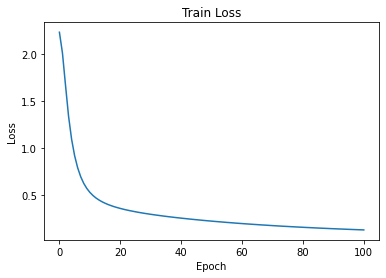

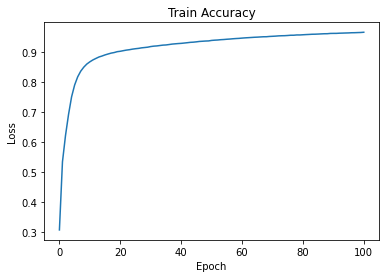

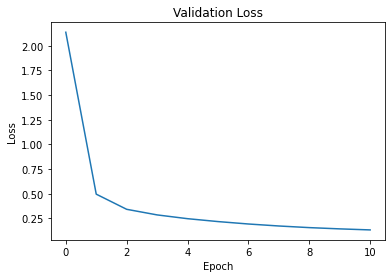

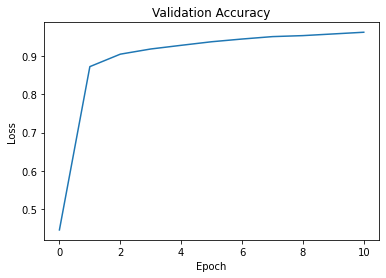

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 1:29:05 ago. (Use '!kill 2537' to kill it.)

(884.8141815662384, 99710, 21.025757562369108, 0.9619)

In [22]:
print("__________________LA NORME L2 DE 10^−5 (SGD)__________________")
weight_decay = 10e-5
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-5")

#### Pour la norme L2 de 10^-4


__________________LA NORME L2 DE 10^-4 (Adam)__________________
	Epoch 0, Validation Loss: 26.7110, Validation Accuracy: 0.9456
Epoch 1, Train Loss: 0.1704, Train Accuracy: 0.9487
Epoch 2, Train Loss: 0.1408, Train Accuracy: 0.9571
Epoch 3, Train Loss: 0.1280, Train Accuracy: 0.9599
Epoch 4, Train Loss: 0.1186, Train Accuracy: 0.9637
Epoch 5, Train Loss: 0.1161, Train Accuracy: 0.9644
Epoch 6, Train Loss: 0.1091, Train Accuracy: 0.9664
Epoch 7, Train Loss: 0.1125, Train Accuracy: 0.9650
Epoch 8, Train Loss: 0.1118, Train Accuracy: 0.9657
Epoch 9, Train Loss: 0.1108, Train Accuracy: 0.9655
	Epoch 10, Validation Loss: 20.6778, Validation Accuracy: 0.9581
Epoch 11, Train Loss: 0.1024, Train Accuracy: 0.9686
Epoch 12, Train Loss: 0.1055, Train Accuracy: 0.9675
Epoch 13, Train Loss: 0.1020, Train Accuracy: 0.9681
Epoch 14, Train Loss: 0.0982, Train Accuracy: 0.9697
Epoch 15, Train Loss: 0.1020, Train Accuracy: 0.9690
Epoch 16, Train Loss: 0.0963, Train Accuracy: 0.9700
Epoch 17, Train Loss

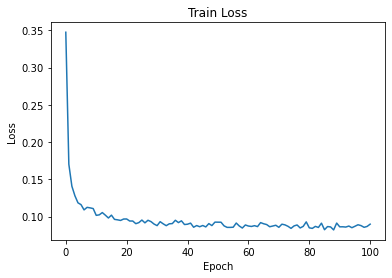

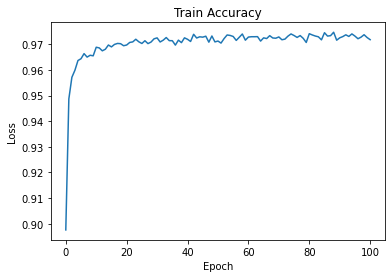

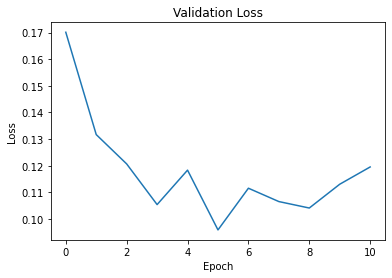

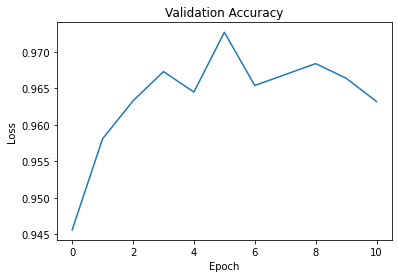

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 1:44:40 ago. (Use '!kill 2537' to kill it.)

(934.3008387088776, 99710, 18.768522571539506, 0.9632)

In [23]:
print("\n__________________LA NORME L2 DE 10^-4 (Adam)__________________")
weight_decay = 10e-4
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-4")


__________________LA NORME L2 DE 10^-4 (SGD)__________________
	Epoch 0, Validation Loss: 338.2088, Validation Accuracy: 0.5322
Epoch 1, Train Loss: 2.0461, Train Accuracy: 0.5732
Epoch 2, Train Loss: 1.7398, Train Accuracy: 0.6155
Epoch 3, Train Loss: 1.3891, Train Accuracy: 0.6838
Epoch 4, Train Loss: 1.1062, Train Accuracy: 0.7503
Epoch 5, Train Loss: 0.9116, Train Accuracy: 0.7926
Epoch 6, Train Loss: 0.7782, Train Accuracy: 0.8212
Epoch 7, Train Loss: 0.6837, Train Accuracy: 0.8410
Epoch 8, Train Loss: 0.6141, Train Accuracy: 0.8542
Epoch 9, Train Loss: 0.5614, Train Accuracy: 0.8650
	Epoch 10, Validation Loss: 76.9151, Validation Accuracy: 0.8787
Epoch 11, Train Loss: 0.4883, Train Accuracy: 0.8780
Epoch 12, Train Loss: 0.4624, Train Accuracy: 0.8823
Epoch 13, Train Loss: 0.4409, Train Accuracy: 0.8859
Epoch 14, Train Loss: 0.4232, Train Accuracy: 0.8887
Epoch 15, Train Loss: 0.4082, Train Accuracy: 0.8922
Epoch 16, Train Loss: 0.3952, Train Accuracy: 0.8951
Epoch 17, Train Loss

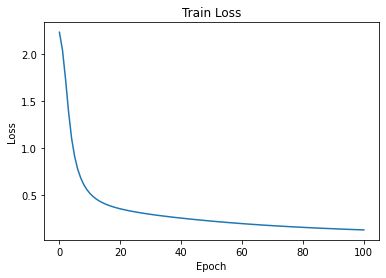

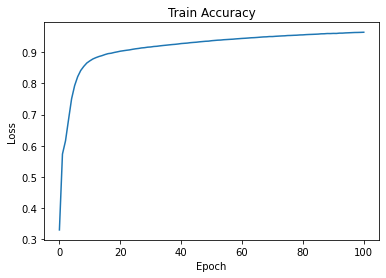

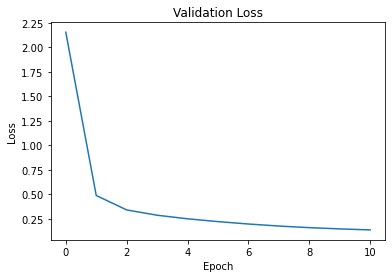

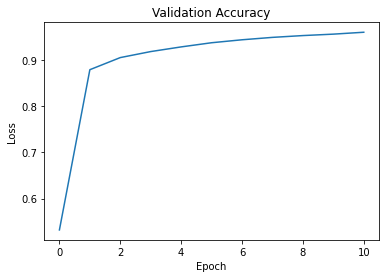

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 1:59:22 ago. (Use '!kill 2537' to kill it.)

(881.9688005447388, 99710, 21.792352315504104, 0.9597)

In [24]:
print("\n__________________LA NORME L2 DE 10^-4 (SGD)__________________")
weight_decay = 10e-4
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-4")

#### Pour la norme L2 de 10^-3


__________________LA NORME L2 DE 10^-3 (Adam)__________________
	Epoch 0, Validation Loss: 46.8105, Validation Accuracy: 0.9166
Epoch 1, Train Loss: 0.2643, Train Accuracy: 0.9255
Epoch 2, Train Loss: 0.2400, Train Accuracy: 0.9323
Epoch 3, Train Loss: 0.2293, Train Accuracy: 0.9362
Epoch 4, Train Loss: 0.2246, Train Accuracy: 0.9382
Epoch 5, Train Loss: 0.2239, Train Accuracy: 0.9391
Epoch 6, Train Loss: 0.2203, Train Accuracy: 0.9400
Epoch 7, Train Loss: 0.2214, Train Accuracy: 0.9395
Epoch 8, Train Loss: 0.2174, Train Accuracy: 0.9402
Epoch 9, Train Loss: 0.2198, Train Accuracy: 0.9394
	Epoch 10, Validation Loss: 30.9526, Validation Accuracy: 0.9430
Epoch 11, Train Loss: 0.2201, Train Accuracy: 0.9393
Epoch 12, Train Loss: 0.2133, Train Accuracy: 0.9415
Epoch 13, Train Loss: 0.2165, Train Accuracy: 0.9406
Epoch 14, Train Loss: 0.2169, Train Accuracy: 0.9408
Epoch 15, Train Loss: 0.2123, Train Accuracy: 0.9419
Epoch 16, Train Loss: 0.2107, Train Accuracy: 0.9436
Epoch 17, Train Loss

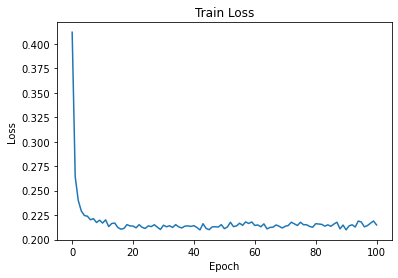

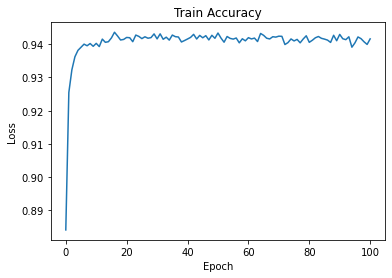

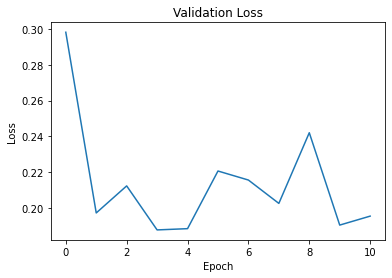

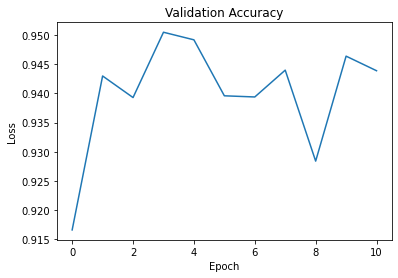

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 2:14:55 ago. (Use '!kill 2537' to kill it.)

(932.755523443222, 99710, 30.674762593582273, 0.9439)

In [25]:
print("\n__________________LA NORME L2 DE 10^-3 (Adam)__________________")
weight_decay = 10e-3
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-3")


__________________LA NORME L2 DE 10^-3 (SGD)__________________
	Epoch 0, Validation Loss: 337.7324, Validation Accuracy: 0.4961
Epoch 1, Train Loss: 2.0452, Train Accuracy: 0.5373
Epoch 2, Train Loss: 1.7538, Train Accuracy: 0.5861
Epoch 3, Train Loss: 1.4508, Train Accuracy: 0.6343
Epoch 4, Train Loss: 1.2096, Train Accuracy: 0.6935
Epoch 5, Train Loss: 1.0240, Train Accuracy: 0.7489
Epoch 6, Train Loss: 0.8835, Train Accuracy: 0.7889
Epoch 7, Train Loss: 0.7790, Train Accuracy: 0.8151
Epoch 8, Train Loss: 0.7010, Train Accuracy: 0.8332
Epoch 9, Train Loss: 0.6415, Train Accuracy: 0.8452
	Epoch 10, Validation Loss: 87.8844, Validation Accuracy: 0.8655
Epoch 11, Train Loss: 0.5577, Train Accuracy: 0.8629
Epoch 12, Train Loss: 0.5272, Train Accuracy: 0.8698
Epoch 13, Train Loss: 0.5022, Train Accuracy: 0.8753
Epoch 14, Train Loss: 0.4812, Train Accuracy: 0.8792
Epoch 15, Train Loss: 0.4634, Train Accuracy: 0.8829
Epoch 16, Train Loss: 0.4484, Train Accuracy: 0.8857
Epoch 17, Train Loss

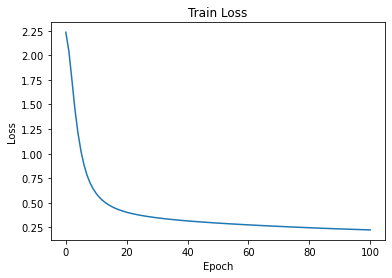

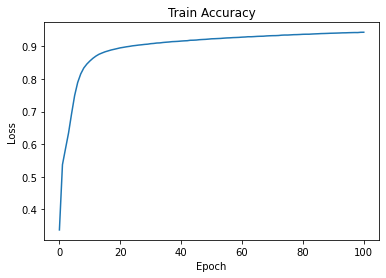

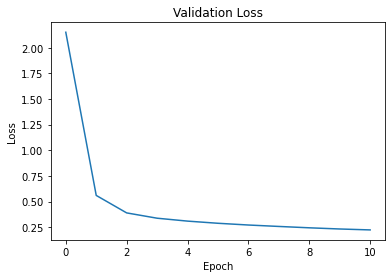

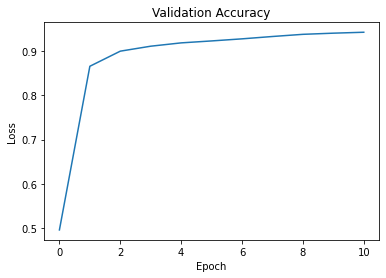

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 2:29:35 ago. (Use '!kill 2537' to kill it.)

(878.9981255531311, 99710, 35.07422340102494, 0.9423)

In [26]:
print("\n__________________LA NORME L2 DE 10^-3 (SGD)__________________")
weight_decay = 10e-3
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-3")

#### Pour la norme L2 de 0


__________________LA NORME L2 DE 0 (Adam)__________________
	Epoch 0, Validation Loss: 36.6204, Validation Accuracy: 0.9264
Epoch 1, Train Loss: 0.1688, Train Accuracy: 0.9490
Epoch 2, Train Loss: 0.1373, Train Accuracy: 0.9579
Epoch 3, Train Loss: 0.1207, Train Accuracy: 0.9629
Epoch 4, Train Loss: 0.1081, Train Accuracy: 0.9666
Epoch 5, Train Loss: 0.0974, Train Accuracy: 0.9695
Epoch 6, Train Loss: 0.0928, Train Accuracy: 0.9708
Epoch 7, Train Loss: 0.0903, Train Accuracy: 0.9712
Epoch 8, Train Loss: 0.0866, Train Accuracy: 0.9727
Epoch 9, Train Loss: 0.0798, Train Accuracy: 0.9744
	Epoch 10, Validation Loss: 16.8298, Validation Accuracy: 0.9684
Epoch 11, Train Loss: 0.0716, Train Accuracy: 0.9771
Epoch 12, Train Loss: 0.0714, Train Accuracy: 0.9771
Epoch 13, Train Loss: 0.0665, Train Accuracy: 0.9782
Epoch 14, Train Loss: 0.0628, Train Accuracy: 0.9799
Epoch 15, Train Loss: 0.0613, Train Accuracy: 0.9803
Epoch 16, Train Loss: 0.0577, Train Accuracy: 0.9817
Epoch 17, Train Loss: 0.

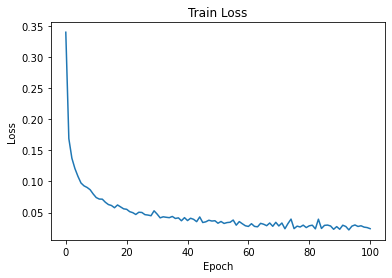

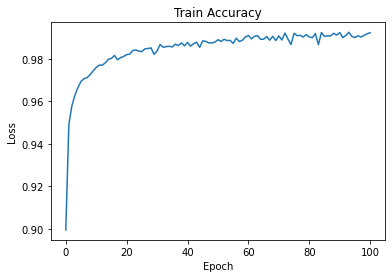

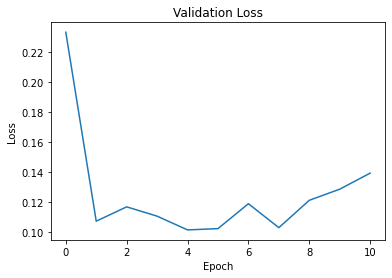

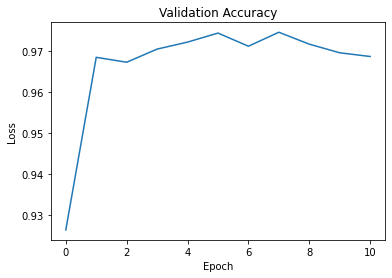

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 2:45:00 ago. (Use '!kill 2537' to kill it.)

(925.530693769455, 99710, 21.864432655675046, 0.9686)

In [27]:
print("\n__________________LA NORME L2 DE 0 (Adam)__________________")
weight_decay = 0
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-0")


__________________LA NORME L2 DE 0 (SGD)__________________
	Epoch 0, Validation Loss: 333.2330, Validation Accuracy: 0.5159
Epoch 1, Train Loss: 1.9834, Train Accuracy: 0.5598
Epoch 2, Train Loss: 1.6352, Train Accuracy: 0.6182
Epoch 3, Train Loss: 1.3093, Train Accuracy: 0.6794
Epoch 4, Train Loss: 1.0684, Train Accuracy: 0.7375
Epoch 5, Train Loss: 0.8985, Train Accuracy: 0.7818
Epoch 6, Train Loss: 0.7799, Train Accuracy: 0.8090
Epoch 7, Train Loss: 0.6949, Train Accuracy: 0.8264
Epoch 8, Train Loss: 0.6315, Train Accuracy: 0.8397
Epoch 9, Train Loss: 0.5815, Train Accuracy: 0.8509
	Epoch 10, Validation Loss: 79.7454, Validation Accuracy: 0.8696
Epoch 11, Train Loss: 0.5079, Train Accuracy: 0.8681
Epoch 12, Train Loss: 0.4797, Train Accuracy: 0.8747
Epoch 13, Train Loss: 0.4558, Train Accuracy: 0.8802
Epoch 14, Train Loss: 0.4354, Train Accuracy: 0.8840
Epoch 15, Train Loss: 0.4177, Train Accuracy: 0.8882
Epoch 16, Train Loss: 0.4025, Train Accuracy: 0.8920
Epoch 17, Train Loss: 0.

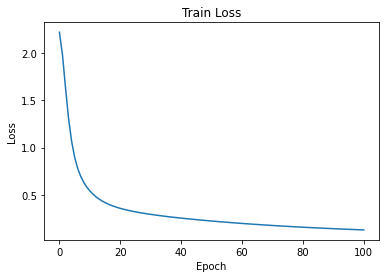

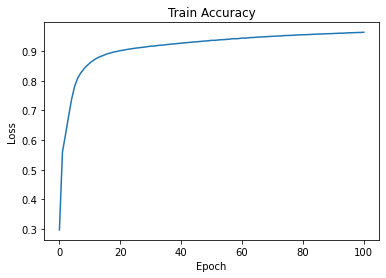

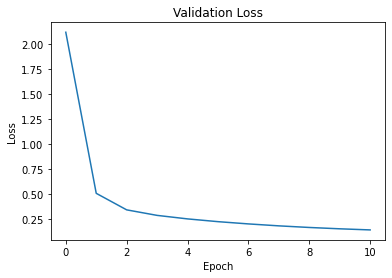

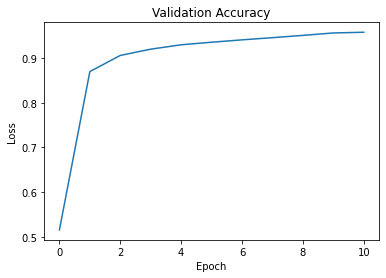

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2537), started 2:59:39 ago. (Use '!kill 2537' to kill it.)

(878.6653764247894, 99710, 22.160943056922406, 0.9574)

In [28]:
print("\n__________________LA NORME L2 DE 0 (SGD)__________________")
weight_decay = 0
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-0")

## Modèle LinearMultiClassWithDropout

Une autre technique très utilisée est le <a href=https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html> **Dropout** </a>. L’idée du Dropout est proche du moyennage de modèle : en entraînant k modèles de manière indépendante, on réduit la variance du modèle. Entraîner k modèles présente un surcoût non négligeable, et l’intérêt du Dropout est de réduire la complexité mémoire/temps de calcul. Le Dropout consiste à chaque itération à *geler* certains neurones aléatoirement dans le réseau en fixant leur sortie à zéro. Cela a pour conséquence de rendre plus robuste le réseau.

	Epoch 0, Validation Loss: 54.6335, Validation Accuracy: 0.8970
Epoch 1, Train Loss: 0.4614, Train Accuracy: 0.8669
Epoch 2, Train Loss: 0.4170, Train Accuracy: 0.8808
Epoch 3, Train Loss: 0.3945, Train Accuracy: 0.8876
Epoch 4, Train Loss: 0.3783, Train Accuracy: 0.8928
Epoch 5, Train Loss: 0.3661, Train Accuracy: 0.8964
Epoch 6, Train Loss: 0.3581, Train Accuracy: 0.8988
Epoch 7, Train Loss: 0.3511, Train Accuracy: 0.9010
Epoch 8, Train Loss: 0.3476, Train Accuracy: 0.9030
Epoch 9, Train Loss: 0.3442, Train Accuracy: 0.9021
	Epoch 10, Validation Loss: 33.0559, Validation Accuracy: 0.9405
Epoch 11, Train Loss: 0.3356, Train Accuracy: 0.9044
Epoch 12, Train Loss: 0.3279, Train Accuracy: 0.9084
Epoch 13, Train Loss: 0.3326, Train Accuracy: 0.9055
Epoch 14, Train Loss: 0.3223, Train Accuracy: 0.9094
Epoch 15, Train Loss: 0.3161, Train Accuracy: 0.9113
Epoch 16, Train Loss: 0.3171, Train Accuracy: 0.9107
Epoch 17, Train Loss: 0.3135, Train Accuracy: 0.9125
Epoch 18, Train Loss: 0.3116, Tr

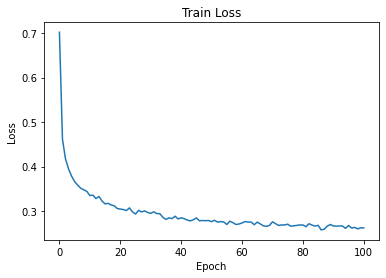

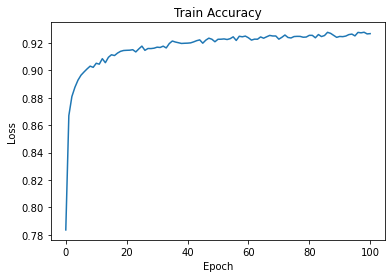

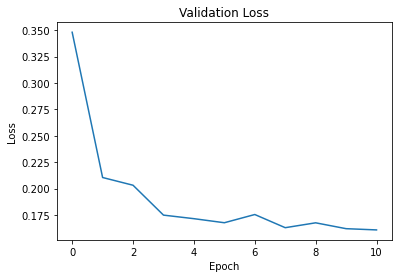

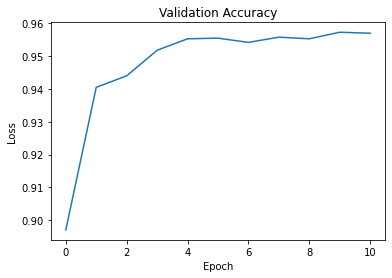

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
dropout_rate = 0.5
model = LinearMultiClassWithDropout(in_size, out_size, hidden_layers, dropout_rate)

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model Dropout
model2ExecutionTimeAdam, model2ComplexityAdam, model2ValidationLossAdam, model2AccuracyAdam = train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, dropout_rate=dropout_rate, typeTrain="Dropout-Adam")

	Epoch 0, Validation Loss: 338.2461, Validation Accuracy: 0.5464
Epoch 1, Train Loss: 2.0785, Train Accuracy: 0.3791
Epoch 2, Train Loss: 1.8187, Train Accuracy: 0.5102
Epoch 3, Train Loss: 1.5491, Train Accuracy: 0.5670
Epoch 4, Train Loss: 1.3335, Train Accuracy: 0.6137
Epoch 5, Train Loss: 1.1712, Train Accuracy: 0.6535
Epoch 6, Train Loss: 1.0550, Train Accuracy: 0.6872
Epoch 7, Train Loss: 0.9651, Train Accuracy: 0.7136
Epoch 8, Train Loss: 0.8889, Train Accuracy: 0.7373
Epoch 9, Train Loss: 0.8279, Train Accuracy: 0.7558
	Epoch 10, Validation Loss: 88.9768, Validation Accuracy: 0.8493
Epoch 11, Train Loss: 0.7342, Train Accuracy: 0.7831
Epoch 12, Train Loss: 0.7026, Train Accuracy: 0.7917
Epoch 13, Train Loss: 0.6731, Train Accuracy: 0.8006
Epoch 14, Train Loss: 0.6476, Train Accuracy: 0.8087
Epoch 15, Train Loss: 0.6241, Train Accuracy: 0.8159
Epoch 16, Train Loss: 0.6076, Train Accuracy: 0.8197
Epoch 17, Train Loss: 0.5915, Train Accuracy: 0.8257
Epoch 18, Train Loss: 0.5822, T

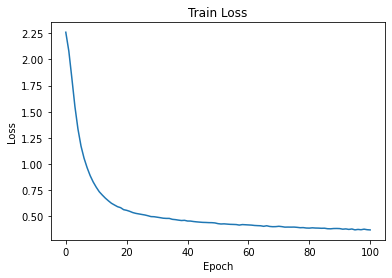

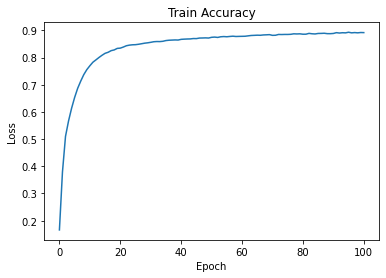

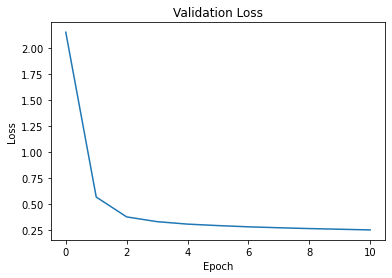

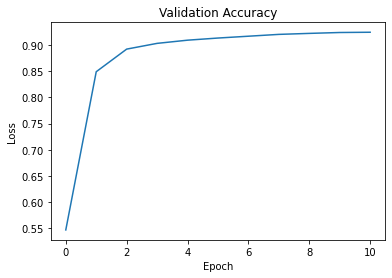

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 5481), started 0:15:30 ago. (Use '!kill 5481' to kill it.)

In [30]:
dropout_rate = 0.5
model = LinearMultiClassWithDropout(in_size, out_size, hidden_layers, dropout_rate)

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Train the model Dropout
model2ExecutionTimeSGD, model2ComplexitySGD, model2ValidationLossSGD, model2AccuracySGD = train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, dropout_rate=dropout_rate, typeTrain="Dropout-SGD")

## Modèle LinearMultiClassWithBatchNorm

On sait que les données centrées réduites permettent un apprentissage plus rapide et stable d’un modèle ; bien qu’on puisse faire en sorte que les données en entrées soient centrées réduites, cela est plus délicat pour les couches internes d’un réseau de neurones. La technique de <a href=https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html> **BatchNorm**</a> consiste à ajouter une couche qui a pour but de centrer/réduire les données en utilisant une moyenne/variance glissante (en inférence) et les statistiques du batch (en
apprentissage).

<ipython-input-4-8096a4ae721a>:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation(x)


	Epoch 0, Validation Loss: 131.9683, Validation Accuracy: 0.9588
Epoch 1, Train Loss: 0.5639, Train Accuracy: 0.9526
Epoch 2, Train Loss: 0.2696, Train Accuracy: 0.9670
Epoch 3, Train Loss: 0.1668, Train Accuracy: 0.9743
Epoch 4, Train Loss: 0.1222, Train Accuracy: 0.9782
Epoch 5, Train Loss: 0.0972, Train Accuracy: 0.9807
Epoch 6, Train Loss: 0.0803, Train Accuracy: 0.9835
Epoch 7, Train Loss: 0.0687, Train Accuracy: 0.9847
Epoch 8, Train Loss: 0.0620, Train Accuracy: 0.9859
Epoch 9, Train Loss: 0.0555, Train Accuracy: 0.9872
	Epoch 10, Validation Loss: 13.5157, Validation Accuracy: 0.9784
Epoch 11, Train Loss: 0.0462, Train Accuracy: 0.9890
Epoch 12, Train Loss: 0.0400, Train Accuracy: 0.9904
Epoch 13, Train Loss: 0.0379, Train Accuracy: 0.9907
Epoch 14, Train Loss: 0.0327, Train Accuracy: 0.9919
Epoch 15, Train Loss: 0.0329, Train Accuracy: 0.9917
Epoch 16, Train Loss: 0.0313, Train Accuracy: 0.9922
Epoch 17, Train Loss: 0.0292, Train Accuracy: 0.9929
Epoch 18, Train Loss: 0.0274, T

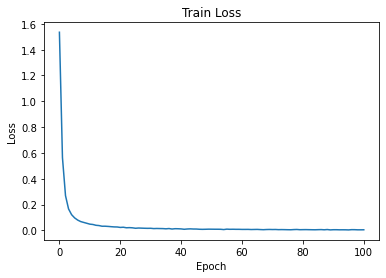

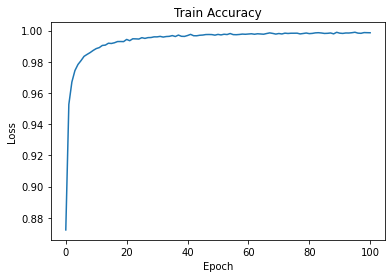

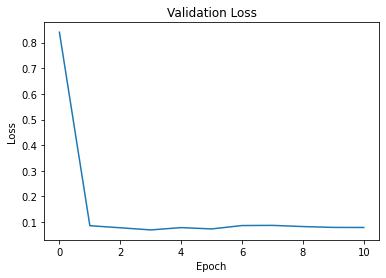

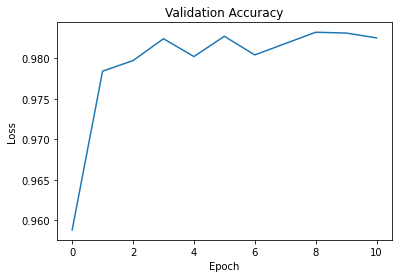

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
model = LinearMultiClassWithBatchNorm(in_size=784, out_size=10, hidden_layers=[256, 128, 64], activation=nn.Softmax())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model3ExecutionTimeAdam, model3ComplexityAdam, model3ValidationLossAdam, model3AccuracyAdam = train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="BatchNorm-Adam")

<ipython-input-4-8096a4ae721a>:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation(x)


	Epoch 0, Validation Loss: 361.5217, Validation Accuracy: 0.1445
Epoch 1, Train Loss: 2.3009, Train Accuracy: 0.1669
Epoch 2, Train Loss: 2.2984, Train Accuracy: 0.2242
Epoch 3, Train Loss: 2.2961, Train Accuracy: 0.2561
Epoch 4, Train Loss: 2.2939, Train Accuracy: 0.2556
Epoch 5, Train Loss: 2.2918, Train Accuracy: 0.2627
Epoch 6, Train Loss: 2.2899, Train Accuracy: 0.3250
Epoch 7, Train Loss: 2.2880, Train Accuracy: 0.3219
Epoch 8, Train Loss: 2.2863, Train Accuracy: 0.3048
Epoch 9, Train Loss: 2.2845, Train Accuracy: 0.2759
	Epoch 10, Validation Loss: 357.9561, Validation Accuracy: 0.2673
Epoch 11, Train Loss: 2.2812, Train Accuracy: 0.2454
Epoch 12, Train Loss: 2.2797, Train Accuracy: 0.2314
Epoch 13, Train Loss: 2.2781, Train Accuracy: 0.2237
Epoch 14, Train Loss: 2.2764, Train Accuracy: 0.2207
Epoch 15, Train Loss: 2.2748, Train Accuracy: 0.2150
Epoch 16, Train Loss: 2.2732, Train Accuracy: 0.2149
Epoch 17, Train Loss: 2.2716, Train Accuracy: 0.2134
Epoch 18, Train Loss: 2.2700, 

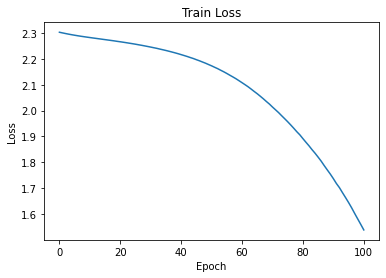

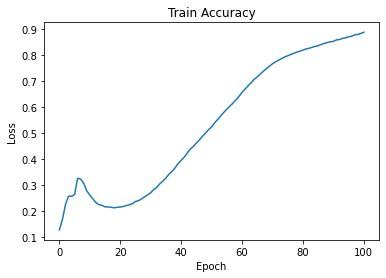

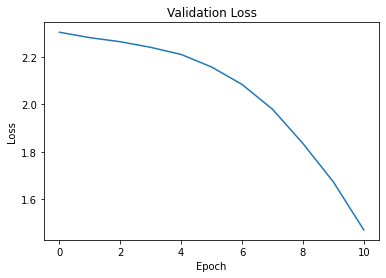

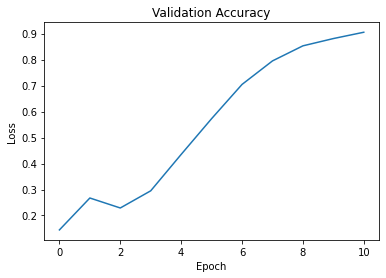

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 6031), started 0:15:28 ago. (Use '!kill 6031' to kill it.)

In [32]:
model = LinearMultiClassWithBatchNorm(in_size=784, out_size=10, hidden_layers=[256, 128, 64], activation=nn.Softmax())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model3ExecutionTimeSGD, model3ComplexitySGD, model3ValidationLossSGD, model3AccuracySGD = train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="BatchNorm-SGD")

# Fonction de comparaison des modèles 

Cette fonction renvoie maintenant des informations détaillées sur les deux modèles, y compris la perte, la précision, la complexité en termes de nombre de paramètres et le temps d'évaluation sur les données de validation. 

Pour comparer les performances d'un modèle sur des données de validation, il est plus pratique de comparer les moyennes des pertes de validation (validation_loss) calculées sur l'ensemble des données de validation pour chaque époque.

<span style="color: red;">N.B.</span> <span style="font-style: italic;">L'accuracy est un métrique couramment utilisé pour évaluer la performance d'un modèle de classification. C'est la proportion de prédictions correctes que le modèle fait par rapport au nombre total de prédictions. L'accuracy est généralement exprimée en pourcentage et peut être calculée en comparant les étiquettes prévues par le modèle avec les étiquettes réelles. Plus l'accuracy est élevée, meilleure est la performance du modèle.</span>

In [40]:
def compare_models(executionTimeOfModel1, complexityOfModel1, validationLossOfModel1, accuracyOfModel1, executionTimeOfModel2, complexityOfModel2, validationLossOfModel2, accuracyOfModel2):
    print("Le modèle 1 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel1, accuracyOfModel1*100, complexityOfModel1, executionTimeOfModel1))
    print("\nLe modèle 2 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel2, accuracyOfModel2*100, complexityOfModel2, executionTimeOfModel2))

    if validationLossOfModel1 < validationLossOfModel2:
        print("\n\tLe modèle 1 a une perte plus faible sur les données de validation.")
        return 1
    else:
        print("\n\tLe modèle 2 a une perte plus faible sur les données de validation.")
        return 2

# Comparaison des données des modèles

## Pour : LinearMultiClass VS LinearMultiClassWithDropout

In [41]:
resultTest1 = compare_models(model1ExecutionTimeTanhAdam, model1ComplexityTanhAdam, model1ValidationLossTanhAdam, model1AccuracyTanhAdam, model2ExecutionTimeAdam, model2ComplexityAdam, model2ValidationLossAdam, model2AccuracyAdam)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithDropout (Adam) est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 12.12764191540191 sur les données de validation avec une précision de 97.56% et une complexité de 235146 paramètres et un temps d'évaluation de 926.860333442688s

Le modèle 2 a une perte de 25.271164040081203 sur les données de validation avec une précision de 95.7% et une complexité de 99710 paramètres et un temps d'évaluation de 939.1026420593262s

	Le modèle 1 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle LinearMultiClass (Adam) est le plus performant !
___________________________________________________



In [42]:
resultTest1 = compare_models(model1ExecutionTimeTanhSGD, model1ComplexityTanhSGD, model1ValidationLossTanhSGD, model1AccuracyTanhSGD, model2ExecutionTimeSGD, model2ComplexitySGD, model2ValidationLossSGD, model2AccuracySGD)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (SGD) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithDropout (SGD) est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 290.722198843956 sur les données de validation avec une précision de 64.85% et une complexité de 235146 paramètres et un temps d'évaluation de 895.7596008777618s

Le modèle 2 a une perte de 39.27033077320084 sur les données de validation avec une précision de 92.49000000000001% et une complexité de 99710 paramètres et un temps d'évaluation de 929.892345905304s

	Le modèle 2 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle LinearMultiClassWithDropout (SGD) est le plus performant !
___________________________________________________



## Pour : LinearMultiClass VS LinearMultiClassWithBatchNorm

In [43]:
resultTest2 = compare_models(model1ExecutionTimeTanhAdam, model1ComplexityTanhAdam, model1ValidationLossTanhAdam, model1AccuracyTanhAdam, model3ExecutionTimeAdam, model3ComplexityAdam, model3ValidationLossAdam, model3AccuracyAdam)

if resultTest2 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (Adam) est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 12.12764191540191 sur les données de validation avec une précision de 97.56% et une complexité de 235146 paramètres et un temps d'évaluation de 926.860333442688s

Le modèle 2 a une perte de 12.42110836826032 sur les données de validation avec une précision de 98.25% et une complexité de 243658 paramètres et un temps d'évaluation de 1013.7899467945099s

	Le modèle 1 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle LinearMultiClass (Adam) est le plus performant !
___________________________________________________



In [44]:
resultTest2 = compare_models(model1ExecutionTimeTanhSGD, model1ComplexityTanhSGD, model1ValidationLossTanhSGD, model1AccuracyTanhSGD, model3ExecutionTimeSGD, model3ComplexitySGD, model3ValidationLossSGD, model3AccuracySGD)

if resultTest2 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (SGD) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (SGD) est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 290.722198843956 sur les données de validation avec une précision de 64.85% et une complexité de 235146 paramètres et un temps d'évaluation de 895.7596008777618s

Le modèle 2 a une perte de 231.1338986158371 sur les données de validation avec une précision de 90.51% et une complexité de 243658 paramètres et un temps d'évaluation de 927.2568264007568s

	Le modèle 2 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle LinearMultiClassWithBatchNorm (SGD) est le plus performant !
___________________________________________________



## Pour : LinearMultiClassWithDropout VS LinearMultiClassWithBatchNorm

In [45]:
resultTest3 = compare_models(model2ExecutionTimeAdam, model2ComplexityAdam, model2ValidationLossAdam, model2AccuracyAdam, model3ExecutionTimeAdam, model3ComplexityAdam, model3ValidationLossAdam, model3AccuracyAdam)

if resultTest3 == 1:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithDropout (Adam) est le plus performant !\n________________________________________________________________\n")
else:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (Adam) est le plus performant !\n________________________________________________________________\n")

Le modèle 1 a une perte de 25.271164040081203 sur les données de validation avec une précision de 95.7% et une complexité de 99710 paramètres et un temps d'évaluation de 939.1026420593262s

Le modèle 2 a une perte de 12.42110836826032 sur les données de validation avec une précision de 98.25% et une complexité de 243658 paramètres et un temps d'évaluation de 1013.7899467945099s

	Le modèle 2 a une perte plus faible sur les données de validation.

________________________________________________________________
Le Modèle LinearMultiClassWithBatchNorm (Adam) est le plus performant !
________________________________________________________________



In [46]:
resultTest3 = compare_models(model2ExecutionTimeSGD, model2ComplexitySGD, model2ValidationLossSGD, model2AccuracySGD, model3ExecutionTimeSGD, model3ComplexitySGD, model3ValidationLossSGD, model3AccuracySGD)

if resultTest3 == 1:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithDropout (SGD) est le plus performant !\n________________________________________________________________\n")
else:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (SGD) est le plus performant !\n________________________________________________________________\n")

Le modèle 1 a une perte de 39.27033077320084 sur les données de validation avec une précision de 92.49000000000001% et une complexité de 99710 paramètres et un temps d'évaluation de 929.892345905304s

Le modèle 2 a une perte de 231.1338986158371 sur les données de validation avec une précision de 90.51% et une complexité de 243658 paramètres et un temps d'évaluation de 927.2568264007568s

	Le modèle 1 a une perte plus faible sur les données de validation.

________________________________________________________________
Le Modèle LinearMultiClassWithDropout (SGD) est le plus performant !
________________________________________________________________



# Conclusion
<span style="font-style: italic;"> Nous pouvons donc conclure que le modèle <span style="color:green;">LinearMultiClass</span> est le plus performant des trois (3) modèles que nous avons eu à étudier avec nos jeux de données. En deuxième position <span style="color:yellow;">LinearMultiClassWithBatchNorm</span> et enfin <span style="color:red;">LinearMultiClassWithDropout</span></span> en utilisant l'optimiseur Adam. 

Cependant, dans le cas où nous utilison l'optimiseur SGD. <span style="font-style: italic;"> Nous pouvons remarquer que le modèle <span style="color:green;">LinearMultiClassWithBatchNorm</span> est le plus performant des trois (3) modèles que nous avons eu à étudier avec nos jeux de données. En deuxième position <span style="color:yellow;">LinearMultiClassWithDropout</span> et enfin <span style="color:red;">LinearMultiClass</span></span>. 